# Layer 11

In [4]:
! pip install shap

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import heapq
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import shap
import shap.plots as shap_plots

# Reading Data From CSV files

In [3]:
train_data = pd.read_csv('./train.csv')
valid_data = pd.read_csv('./valid.csv')
test_data = pd.read_csv('./test.csv')

## Extracting X and Y

In [4]:
X_train, y_train = train_data.iloc[:, :-4], train_data.iloc[:, -4:]
X_valid, y_valid = valid_data.iloc[:, :-4], valid_data.iloc[:, -4:]
X_test = test_data.iloc[:, 1:]
y_train_arr = [y_train.iloc[:, i] for i in range(4)]
y_valid_arr = [y_valid.iloc[:, i] for i in range(4)]

# Data Preprocessing

## Checking for missing values

In [5]:
X_train.isnull().sum().sum()

0

In [6]:
X_valid.isnull().sum().sum()

0

In [7]:
X_test.isnull().sum().sum()

0

In [8]:
y_train.isnull().sum()

label_1      0
label_2    480
label_3      0
label_4      0
dtype: int64

In [9]:
y_valid.isnull().sum()

label_1     0
label_2    14
label_3     0
label_4     0
dtype: int64

In [10]:
len(y_train)

28520

Therefore y_train and y_valid label 2 only have missing values

In [11]:
print(f"Missing values percentage of train label 2 column : {y_train_arr[1].isnull().sum()*100/len(y_train)}%")
print(f"Missing values percentage of valid label 2 column : {y_valid_arr[1].isnull().sum()*100/len(y_valid)}%")

Missing values percentage of train label 2 column : 1.6830294530154277%
Missing values percentage of valid label 2 column : 1.8666666666666667%


Since the missing values percentage of train data label 2 column and valid data label 2 column are low, missing values are deleted

In [12]:
train_data_missing_removed = train_data.dropna()
valid_data_missing_removed = valid_data.dropna()
train_data_missing_removed.reset_index(drop=True, inplace=True)
valid_data_missing_removed.reset_index(drop=True, inplace=True)
X_train, y_train = train_data.iloc[:, :-4], train_data.iloc[:, -4:]
X_valid, y_valid = valid_data.iloc[:, :-4], valid_data.iloc[:, -4:]
X_train_missing_removed, y_train_missing_removed = train_data_missing_removed.iloc[:, :-4], train_data_missing_removed.iloc[:, -4:]
X_valid_missing_removed, y_valid_missing_removed = valid_data_missing_removed.iloc[:, :-4], valid_data_missing_removed.iloc[:, -4:]
X_train_arr = [X_train, X_train_missing_removed, X_train, X_train]
X_valid_arr = [X_valid, X_valid_missing_removed, X_valid, X_valid]
X_test_arr = [X_test, X_test, X_test, X_test]

In [13]:
y_train_arr = [y_train.iloc[:, 0], y_train_missing_removed.iloc[:, 1], y_train.iloc[:, 2], y_train.iloc[:, 3]]
y_valid_arr = [y_valid.iloc[:, 0], y_valid_missing_removed.iloc[:, 1], y_valid.iloc[:, 2], y_valid.iloc[:, 3]]

## Scaling

"RobustScaler" standardizes the data, first using training data to calculate scaling parameters and then applying the same transformation to validation and test datasets for consistent scaling in machine learning modeling.

In [14]:
scaler = RobustScaler()
for i in range(4):
  X_train_arr[i] = pd.DataFrame(data=scaler.fit_transform(X_train_arr[i]), columns=X_train_arr[i].columns)
  X_valid_arr[i] = pd.DataFrame(data=scaler.transform(X_valid_arr[i]), columns=X_valid_arr[i].columns)
  X_test_arr[i] = pd.DataFrame(data=scaler.transform(X_test_arr[i]), columns=X_test_arr[i].columns)

# Data Visualization

In [15]:
def visualize_label(y, title, x_title, y_title='Number of rows'):
  unique_classes, class_counts = np.unique(y, return_counts=True)
  plt.bar(unique_classes, class_counts)
  plt.xlabel(x_title)
  plt.ylabel(y_title)
  plt.title(title)
  plt.show()

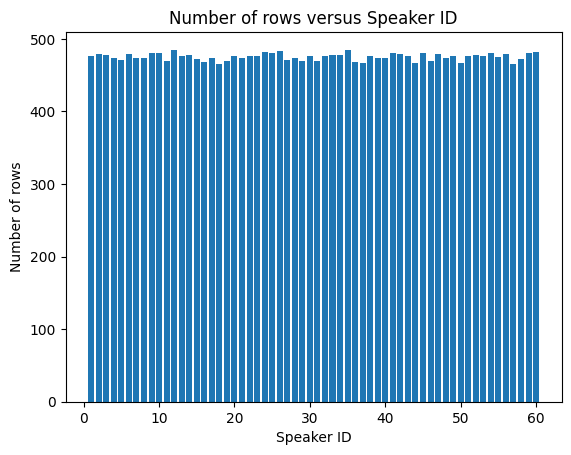

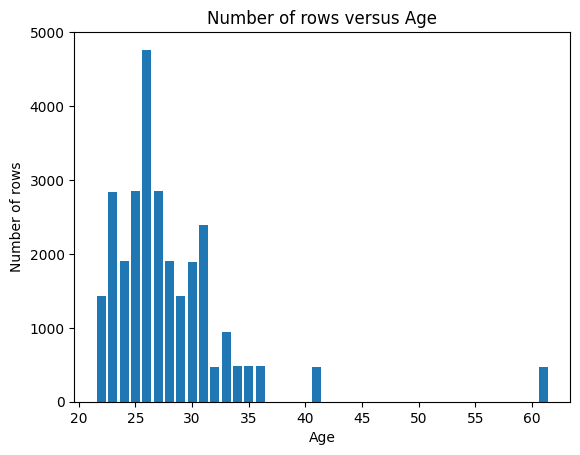

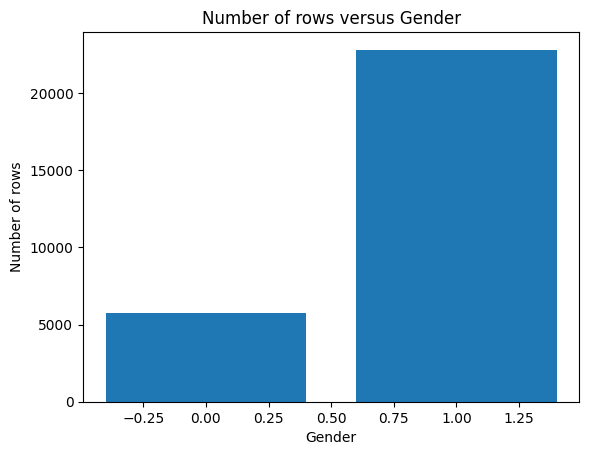

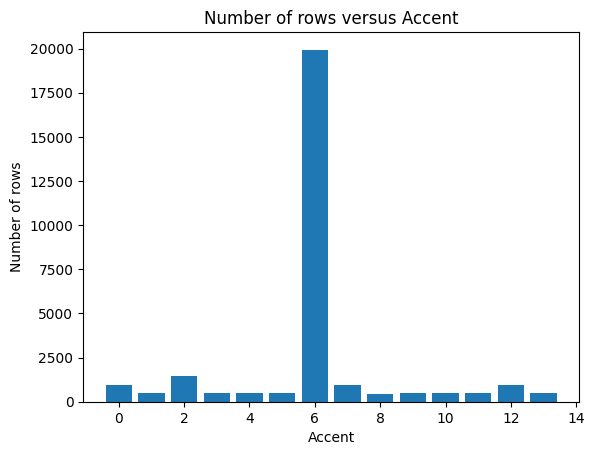

In [16]:
visualize_label(y_train_arr[0], "Number of rows versus Speaker ID","Speaker ID");
visualize_label(y_train_arr[1], "Number of rows versus Age","Age");
visualize_label(y_train_arr[2], "Number of rows versus Gender","Gender");
visualize_label(y_train_arr[3], "Number of rows versus Accent","Accent");

The classes of label 1 are approximately uniformly balanced. In other 3 labes classes are inbalanced. To handle this, class weights are assigned in a latter stage

# Feature Reduction

Principal Component Analysis (PCA) is a tool used to simplify data by reducing its complexity and selecting the most important features. In this context, it's being used to make the features simpler.

In [17]:
def pca_reduce(X,pca, first_fit=False):
  if first_fit:
    X_pca = pca.fit_transform(X)
  else:
    X_pca = pca.transform(X)
  return pd.DataFrame(data=X_pca, columns=[X.columns[i] for i in range(X_pca.shape[1])])

In [18]:
desired_variance_ratio = 0.95
pca = PCA(n_components=desired_variance_ratio, svd_solver='full')
X_train_after_reduction_arr = []
X_valid_after_reduction_arr= []
X_test_after_reduction_arr = []
for i in range(4):
  X_train_after_reduction_arr.append(pca_reduce(X_train_arr[i] ,pca, first_fit=True))
  X_valid_after_reduction_arr.append(pca_reduce(X_valid_arr[i] ,pca))
  X_test_after_reduction_arr.append(pca_reduce(X_test_arr[i] ,pca))

## Useful Functions

In [19]:
def predict(X, model):
  y_pred = model.predict(X)
  return pd.Series(y_pred)

In [20]:
def find_accuracy(y_predicted, y_correct):
  accuracy = accuracy_score(y_predicted, y_correct)
  return accuracy

# Creating models and predicting

Random Forest, kNN and SVC models were considered. After conducting several executions and comparing accuracies SVC models were selected over other two models.

## Random Forest

andom Forest is a practical machine learning approach frequently chosen for its straightforwardness and efficiency in addressing classification tasks.

### Model creating

In [21]:
def random_forest(X, y, n_estimators=100, random_state=42):
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y), class_weights)}
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state, class_weight=class_weight_dict)
    model.fit(X, y)
    return model

In [22]:
random_forest_model_arr = []
for i in range(4):
  random_forest_model_arr.append(random_forest(X_train_after_reduction_arr[i], y_train_arr[i]))

### Predicting for Valid data

In [23]:
y_pred_for_valid_arr = [predict(X_valid_after_reduction_arr[i], random_forest_model_arr[i]) for i in range(4)]
accuracy_for_valid_data_arr = [find_accuracy(y_pred_for_valid_arr[i], y_valid_arr[i]) for i in range(4)]
for i in range(4):
  print(f"Accuracy score for label {i+1} : {accuracy_for_valid_data_arr[i]}")

Accuracy score for label 1 : 0.7986666666666666
Accuracy score for label 2 : 0.65625
Accuracy score for label 3 : 0.928
Accuracy score for label 4 : 0.7346666666666667


## kNN

k-Nearest Neighbors (kNN) is a useful machine learning method often selected for its simplicity and effectiveness in handling classification tasks.

### Model creating

In [24]:
def knn(X, y, n_neighbors=5):
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y), class_weights)}
    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights='uniform')
    model.fit(X, y)
    return model

In [25]:
knn_model_arr = []
for i in range(4):
  knn_model_arr.append(knn(X_train_after_reduction_arr[i], y_train_arr[i]))

### Predicting for Valid data

In [26]:
y_pred_for_valid_arr = [predict(X_valid_after_reduction_arr[i], knn_model_arr[i]) for i in range(4)]
accuracy_for_valid_data_arr = [find_accuracy(y_pred_for_valid_arr[i], y_valid_arr[i]) for i in range(4)]
for i in range(4):
  print(f"Accuracy score for label {i+1} : {accuracy_for_valid_data_arr[i]}")

Accuracy score for label 1 : 0.7733333333333333
Accuracy score for label 2 : 0.7907608695652174
Accuracy score for label 3 : 0.98
Accuracy score for label 4 : 0.8986666666666666


## SVC

Support Vector Classification (SVC) is a machine learning technique used in modeling. It is chosen for its effectiveness in solving classification problems.

### Hyperparameter tuning

The SVM model is tuned using a randomized search approach. Hyperparameter values for 'C', 'gamma', 'kernel' , and 'degree' are explored. RandomizedSearchCV with 100 iterations, 5-fold cross-validation, and parallel processing is applied to find the best combination of hyperparameters for the SVM model.

In [30]:
C = [0.1, 1, 10, 100]
gamma = ['scale', 'auto', 0.001, 0.01, 0.1, 1.0]
kernel = ['linear', 'rbf', 'poly']
degree = [2, 3, 4]
svc_tuning_model = SVC()
param_grid = {
    'C': C,
    'gamma': gamma,
    'kernel': kernel,
    'degree': degree,
}
random_search = RandomizedSearchCV(
    svc_tuning_model,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=40
)
for i in range(4):
  random_search.fit(X_train_after_reduction_arr[i], y_train_arr[i])
  print(random_search.best_params)

### Model creating

class weights are applied to address the issue of imbalanced classes, ensuring that the model effectively learns from all classes in the dataset.

In [27]:
def svm(X, y):
  class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
  class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y), class_weights)}
  model = SVC(kernel='rbf', random_state=40, class_weight=class_weight_dict, C=100)
  model.fit(X, y)
  return model

In [28]:
def svm_linear(X, y):
  class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
  class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y), class_weights)}
  model = SVC(kernel='linear', random_state=40, class_weight=class_weight_dict)
  model.fit(X, y)
  return model

In [29]:
svm_model_arr = []
for i in range(4):
  svm_model_arr.append(svm(X_train_after_reduction_arr[i], y_train_arr[i]))

### Predicting for Valid data

In [30]:
y_pred_for_valid_arr = [predict(X_valid_after_reduction_arr[i], svm_model_arr[i]) for i in range(4)]
accuracy_for_valid_data_arr = [find_accuracy(y_pred_for_valid_arr[i], y_valid_arr[i]) for i in range(4)]
for i in range(4):
  print(f"Accuracy score for label {i+1} : {accuracy_for_valid_data_arr[i]}")

Accuracy score for label 1 : 0.928
Accuracy score for label 2 : 0.8845108695652174
Accuracy score for label 3 : 0.9933333333333333
Accuracy score for label 4 : 0.9413333333333334


# Evaluating

## Cross Validation

This computes and displays the cross-validation scores for each of the four SVM models for their respective labels.

In [35]:
for i in range(4):
  scores = cross_val_score(svm_model_arr[i],X_train_after_reduction_arr[i], y_train_arr[i], cv=5)
  print(f"Cross validations scores for label {i} : {scores}")

Cross validations scores for label 0 : [0.917777   0.92268583 0.91830295 0.91497195 0.91532258]
Cross validations scores for label 1 : [0.41690442 0.625      0.65870185 0.65691869 0.4646933 ]
Cross validations scores for label 2 : [0.96248247 0.99246143 0.98702665 0.97475456 0.99176017]
Cross validations scores for label 3 : [0.89463534 0.88008415 0.88429173 0.89533661 0.85974755]


## Heat Maps of the Confusion Matrixes

 This creates a heatmap representation of a confusion matrix. Then, it calculates and visualizes confusion matrices for different labels: "Speaker ID," "Age," "Gender," and "Accent."

In [31]:
def visualize_confusion(confusion, title):
  plt.figure(figsize=(20, 10))
  sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title(f"Confusion Matrix for {title}")
  plt.show()

In [32]:
confusion_arr = [confusion_matrix(y_valid_arr[i], y_pred_for_valid_arr[i]) for i in range(4)]

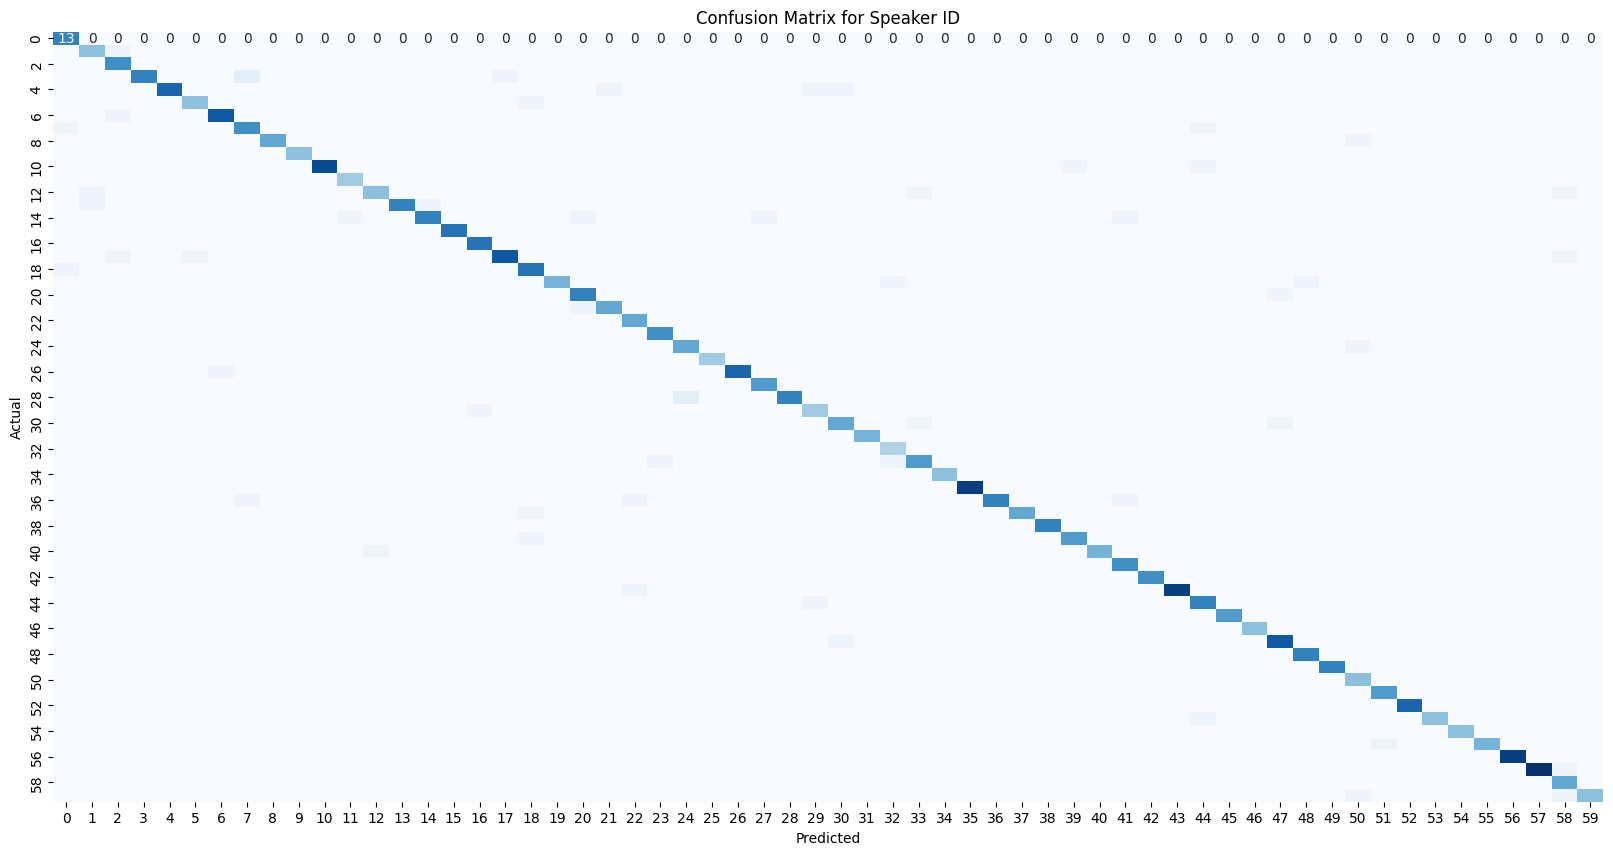

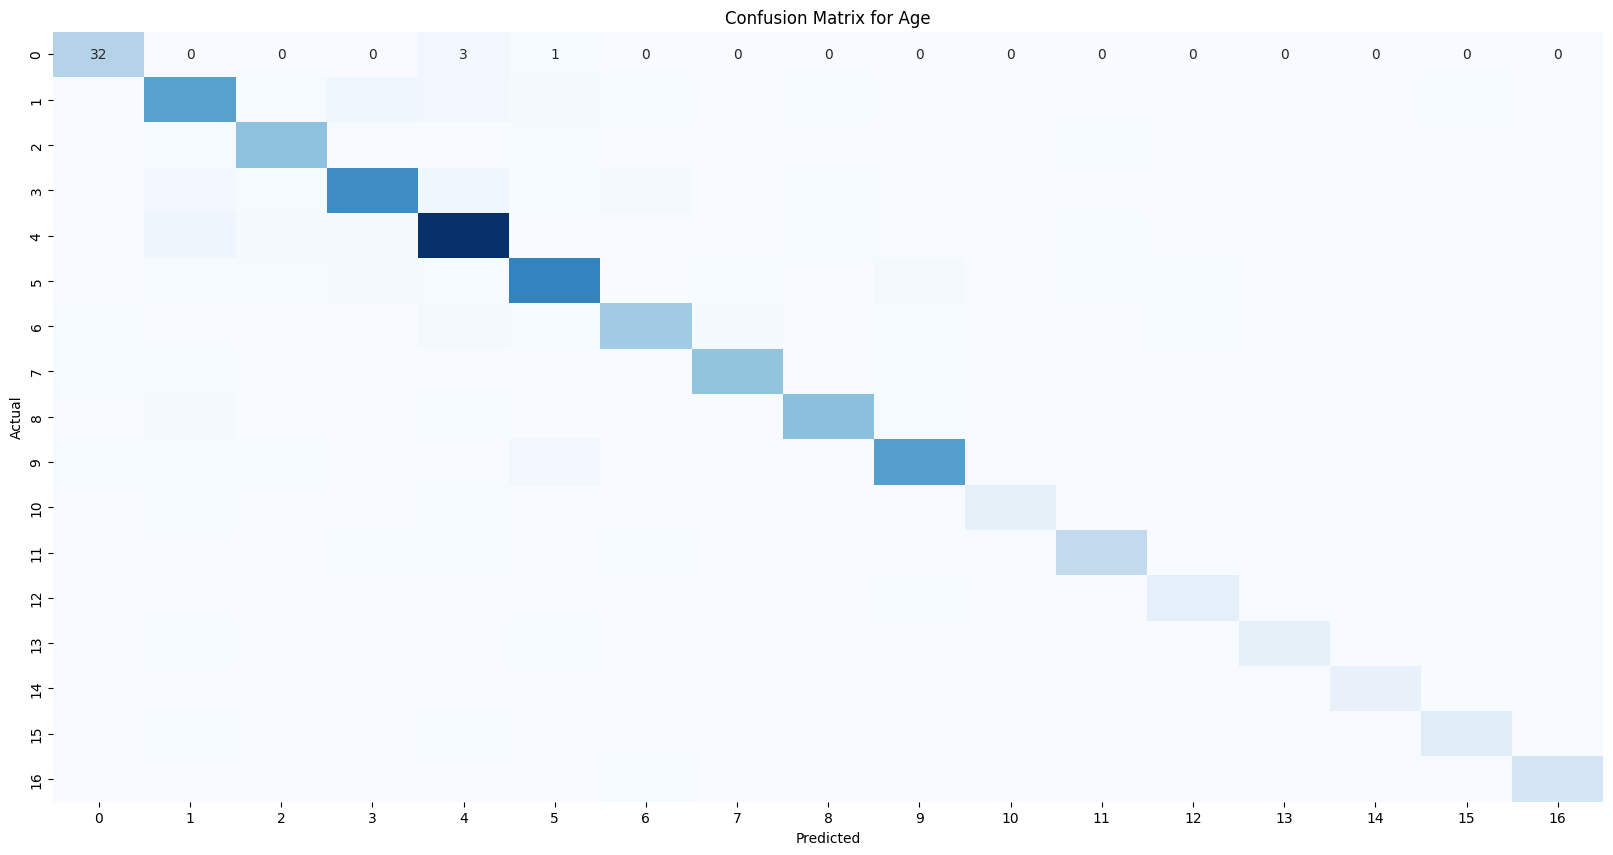

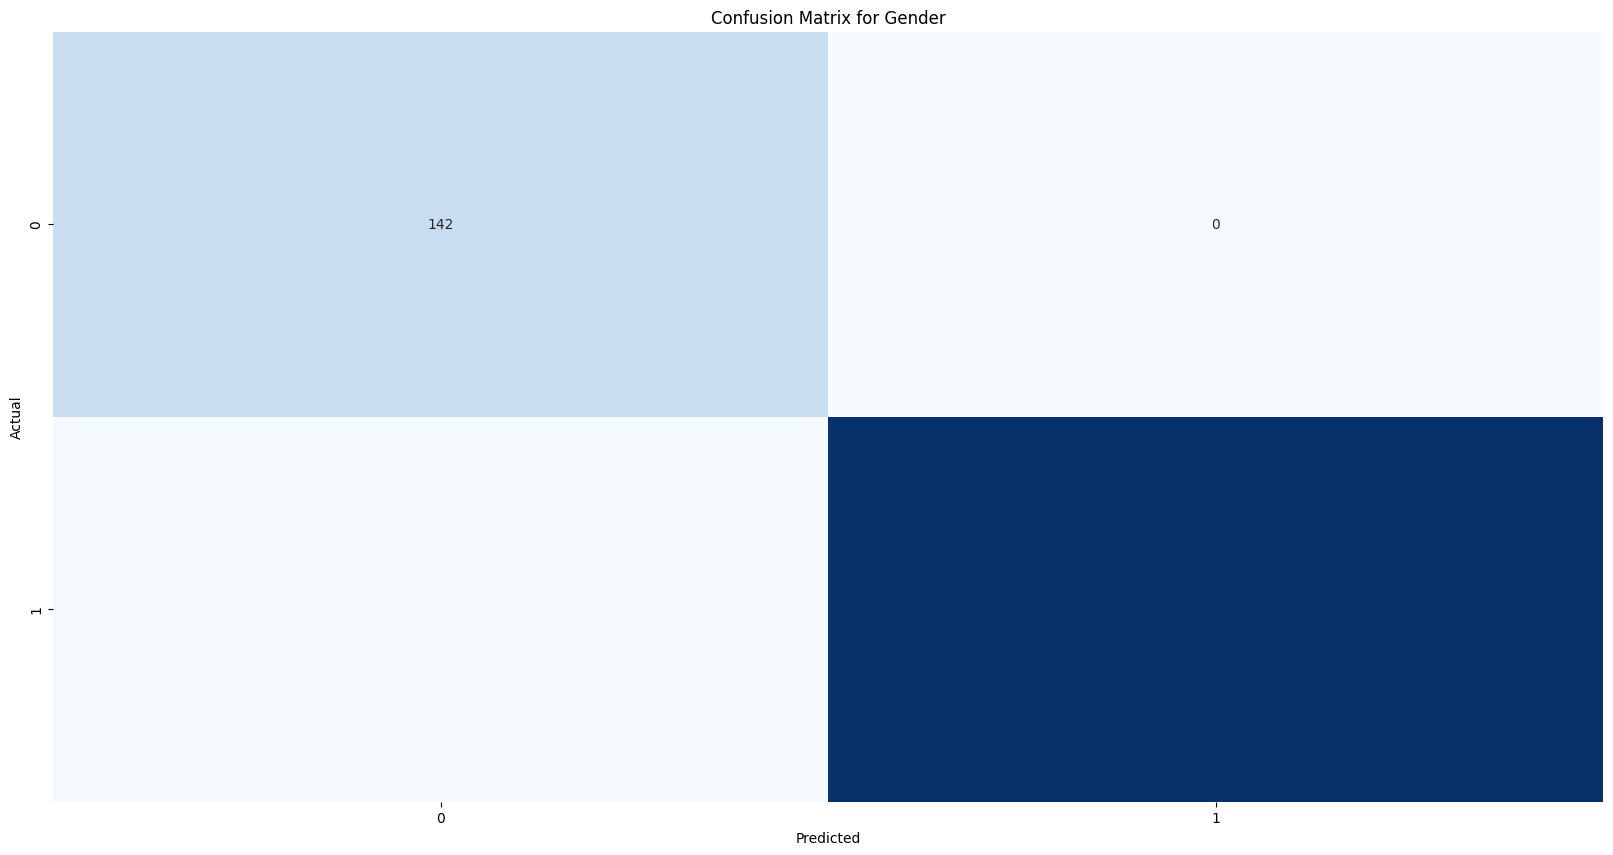

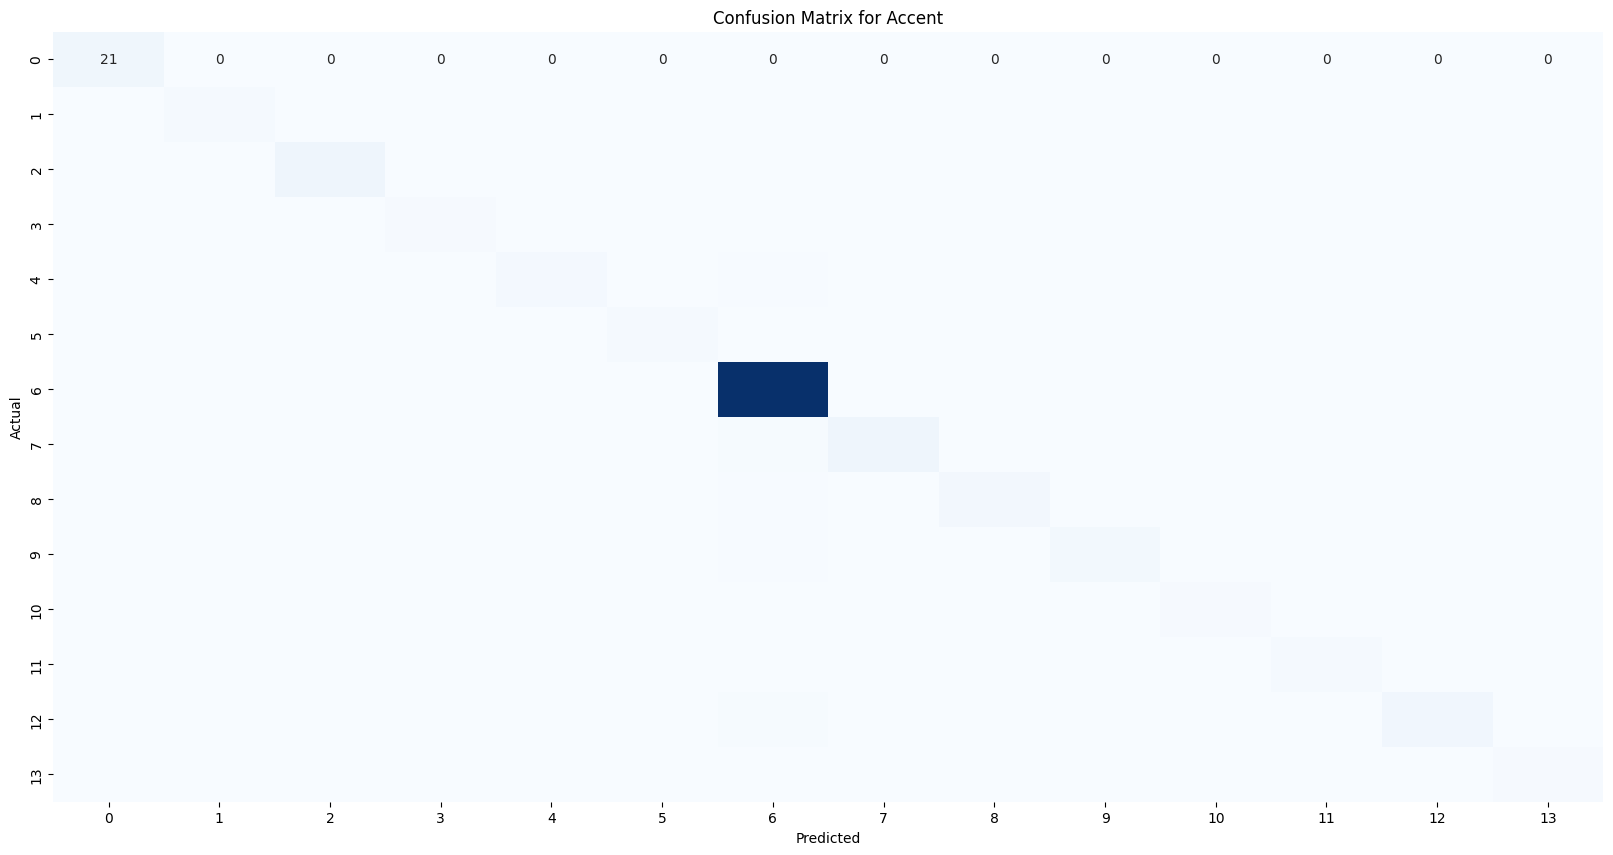

In [33]:
visualize_confusion(confusion_arr[0], "Speaker ID")
visualize_confusion(confusion_arr[1], "Age")
visualize_confusion(confusion_arr[2], "Gender")
visualize_confusion(confusion_arr[3], "Accent")

## Classification Reports

The predictions are generated for validation data using SVM models for four different labels. Then it computes and prints the classification report, including metrics like precision, recall, and F1-score, for each label.

In [34]:
y_pred_for_X_valid_arr = []
accuracy_for_valid_data_arr = []
for i in range(4):
  y_pred_for_X_valid_arr.append(predict(X_valid_after_reduction_arr[i], svm_model_arr[i]))
  accuracy_for_valid_data_arr.append(find_accuracy(y_pred_for_X_valid_arr[i], y_valid_arr[i]))
  print(f"Classification Report for Label {i+1}")
  print(classification_report(y_valid_arr[i], y_pred_for_X_valid_arr[i]))
  print()


Classification Report for Label 1
              precision    recall  f1-score   support

           1       0.87      1.00      0.93        13
           2       0.80      0.89      0.84         9
           3       0.80      1.00      0.89        12
           4       1.00      0.81      0.90        16
           5       1.00      0.83      0.91        18
           6       0.89      0.89      0.89         9
           7       0.94      0.94      0.94        17
           8       0.80      0.86      0.83        14
           9       1.00      0.91      0.95        11
          10       1.00      1.00      1.00         8
          11       1.00      0.89      0.94        19
          12       0.88      1.00      0.93         7
          13       0.89      0.73      0.80        11
          14       1.00      0.87      0.93        15
          15       0.93      0.76      0.84        17
          16       1.00      1.00      1.00        14
          17       0.93      1.00      0.97    

## Accuracies for valid data

In [35]:
for i in range(4):
  print(f"Label {i+1} accuracy for valid data : {accuracy_for_valid_data_arr[i]}")

Label 1 accuracy for valid data : 0.928
Label 2 accuracy for valid data : 0.8845108695652174
Label 3 accuracy for valid data : 0.9933333333333333
Label 4 accuracy for valid data : 0.9413333333333334


# Explainability (Interpreting the label predictions and any cross-relations with labels)

Explaning rbf kernel SVM models are complex. Therefore, to describe the explainability, the linear kernel SVC models are used.

In [39]:
svm_linear_model_arr = [svm_linear(X_train_after_reduction_arr[i], y_train_arr[i]) for i in range(4)]

## SHAP

SHAP is a framework and a set of techniques used in machine learning to explain the predictions made by complex models, such as SVM.

In [ ]:
for i in range(4):
  explainer = shap.Explainer(svm_linear_model_arr[i], X_train_after_reduction_arr[i])
  instance_index = 0
  shap_values = explainer.shap_values(X_test_after_reduction_arr[i])
  shap.summary_plot(shap_values, X_test_after_reduction_arr[i])
  shap.summary_plot(shap_values)

However, due to the high RAM usage of shap.summary_plot and to the complexity, using SHAP was not very effective.

## Using weights assigned to the features

SVC.coef_ are weights assigned to the features when kernel="linear".

In [48]:
def print_top_weight_features(svm_model, n_classes):
  coefficients = svm_model.coef_
  top_weights = []
  for class_A in range(n_classes):
    for class_B in range(class_A + 1, n_classes):
        index = int(class_A * (2 * n_classes - class_A - 1) / 2 + class_B - class_A - 1)
        for feature_index, weight in enumerate(coefficients[index]):
            absolute_weight = np.abs(weight)
            if len(top_weights) < 20:
                heapq.heappush(top_weights, (absolute_weight, feature_index, class_A, class_B, weight))
            else:
                if absolute_weight > top_weights[0][0]:
                    heapq.heappop(top_weights)
                    heapq.heappush(top_weights, (absolute_weight, feature_index, class_A, class_B, weight))
  values_to_print = []
  for i in range(20):
    values_to_print.insert(0, heapq.heappop(top_weights))
  i = 0
  for (absolute_weight, feature_index, class_A, class_B, weight) in values_to_print:
    print(f"Top {i + 1}: The weight assigned to feature {feature_index} between class {class_A} and class {class_B} is {weight}")
    i+=1

In [49]:
for i in range(4):
  print(f"\nFor the Class label {i+1}")
  print_top_weight_features(svm_linear_model_arr[i], len(y_train_arr[i].unique()))



For the Class label 1
Top 1: The weight assigned to feature 97 between class 39 and class 50 is -1.2380471368369959
Top 2: The weight assigned to feature 121 between class 34 and class 50 is -1.23183079729651
Top 3: The weight assigned to feature 37 between class 34 and class 50 is -1.1770529182030334
Top 4: The weight assigned to feature 42 between class 34 and class 50 is 1.1253975568389232
Top 5: The weight assigned to feature 144 between class 39 and class 50 is -1.0964601916079941
Top 6: The weight assigned to feature 69 between class 6 and class 13 is -1.0881169236059556
Top 7: The weight assigned to feature 50 between class 32 and class 38 is 1.0783844617495055
Top 8: The weight assigned to feature 99 between class 39 and class 50 is 1.0617108197259708
Top 9: The weight assigned to feature 81 between class 9 and class 17 is -1.0479768187532852
Top 10: The weight assigned to feature 62 between class 34 and class 47 is -1.0396342967371761
Top 11: The weight assigned to feature 74

According to the above outputs, for the label 1, features 97, 121, 37, 42 and 144 affects more than other features. For the label 2, features 59, 146, 20, 92 and 119 affects more than other features. For the label 3, features 9, 16, 124, 54 and 27 affects more than other features. For the label 4, features 62, 134, 144, 36 and 62 affects more than other features.

## Using constants in the decision function

SVC.intercept_ are constants in decision function.

In [57]:
def print_top_constants(svm_model, n_classes, binary=False):
  intercept = svm_model.intercept_
  top_constants = []
  for class_A in range(n_classes):
    for class_B in range(class_A + 1, n_classes):
        index = int(class_A * (2 * n_classes - class_A - 1) / 2 + class_B - class_A - 1)
        intercept_value = intercept[index]
        absolute_intercept_value = np.abs(intercept[index])
        if len(top_constants) < 20:
            heapq.heappush(top_constants, (absolute_intercept_value, intercept_value, class_A, class_B))
        else:
            if absolute_intercept_value > top_constants[0][0]:
                heapq.heappop(top_constants)
                heapq.heappush(top_constants, (absolute_intercept_value, intercept_value, class_A, class_B))
  values_to_print = []
  if binary:
     values_to_print.append(top_constants[0])
  else:
    for i in range(20):
      values_to_print.insert(0, heapq.heappop(top_constants))
  i = 0
  for (absolute_intercept_value, intercept_value, class_A, class_B) in values_to_print:
    print(f"Top {i + 1}: Intercept/Constant in the decision function is {intercept_value} between the classes {class_A} and {class_B}")
    i+=1

In [58]:
for i in range(4):
  print(f"\nFor the Class Label {i+1}")
  binary = False
  if i==2:
    binary=True
  print_top_constants(svm_linear_model_arr[i], len(y_train_arr[i].unique()), binary=binary)



For the Class Label 1
Top 1: Intercept/Constant in the decision function is 4.089729038014162 between the classes 34 and 47
Top 2: Intercept/Constant in the decision function is -3.4756698157785957 between the classes 11 and 35
Top 3: Intercept/Constant in the decision function is 3.084721289839607 between the classes 35 and 57
Top 4: Intercept/Constant in the decision function is -3.0715766292102313 between the classes 6 and 13
Top 5: Intercept/Constant in the decision function is 3.01203005953284 between the classes 32 and 33
Top 6: Intercept/Constant in the decision function is -2.826718077283088 between the classes 21 and 50
Top 7: Intercept/Constant in the decision function is -2.803232785631701 between the classes 11 and 39
Top 8: Intercept/Constant in the decision function is -2.7170572325252174 between the classes 8 and 39
Top 9: Intercept/Constant in the decision function is -2.6832611059390037 between the classes 8 and 18
Top 10: Intercept/Constant in the decision function i

# Predicting for test data

In [59]:
y_pred_for_X_test_arr = []
for i in range(4):
  y_pred_for_X_test_arr.append(predict(X_test_after_reduction_arr[i], svm_model_arr[i]))

# Creating the solutions csv

In [60]:
def createCSVOutput(y_arr, filename):
  data = {
    'ID' : list(range(1, y_arr[0].shape[0] + 1)),
    'label_1': y_arr[0],
    'label_2': y_arr[1],
    'label_3': y_arr[2],
    'label_4': y_arr[3]
  }
  df = pd.DataFrame(data)
  df.to_csv(filename, index=False)

In [61]:
createCSVOutput(y_pred_for_X_test_arr, './output.csv')